In [1]:
!pip install spacy langdetect wordcloud --no-deps


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=6dcd8af8f048541965119e7a0ecdf827e6c829d07147048a021497eb45d03cf9
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
import re
import string
import wordcloud
from langdetect import detect
from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import words

## EDA

### Read the Data

In [3]:
data_path = '/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv'
df = pd.read_csv(data_path)

In [4]:
df.head(20)

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
5,5,"every break, you must be nervous, like somethi...",Anxiety
6,6,"I feel scared, anxious, what can I do? And may...",Anxiety
7,7,Have you ever felt nervous but didn't know why?,Anxiety
8,8,"I haven't slept well for 2 days, it's like I'm...",Anxiety
9,9,"I'm really worried, I want to cry.",Anxiety


### Data Summary

In [5]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
         Unnamed: 0
count  53043.000000
mean   26521.000000
std    15312.339501
min        0.000000
25%    13260.500000
50%    26521.000000
75%    39781.500000
max    53042.000000


### Check for Missing Value

In [6]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Unnamed: 0      0
statement     362
status          0
dtype: int64


In [7]:
# Display rows with missing values in the 'statement' column
null_df = df[df['statement'].isnull()]
print(null_df)


       Unnamed: 0 statement   status
293           293       NaN  Anxiety
572           572       NaN  Anxiety
595           595       NaN  Anxiety
1539         1539       NaN   Normal
2448         2448       NaN   Normal
...           ...       ...      ...
52838       52838       NaN  Anxiety
52870       52870       NaN  Anxiety
52936       52936       NaN  Anxiety
53010       53010       NaN  Anxiety
53031       53031       NaN  Anxiety

[362 rows x 3 columns]


### Label Distribution

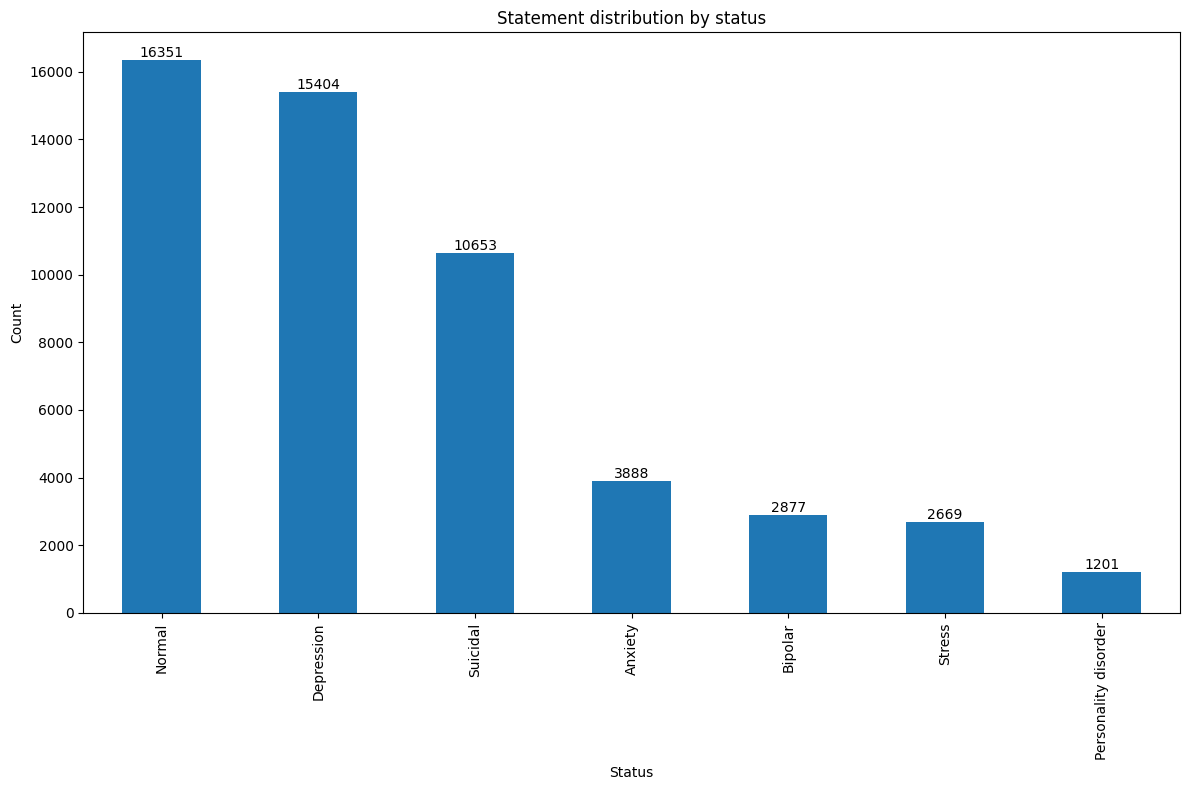

In [8]:
plt.figure(figsize=(12,8))

# get the unique status values and their counts
status_counts = df['status'].value_counts()

# create the bar plot
ax = status_counts.plot(kind='bar')

# add the count labels on top of each bar
for i, v in enumerate(status_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Statement distribution by status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show() 

### Check for Duplicate Data

In [9]:
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


### Display the word cloud for each Label

In [10]:
# categories = df['status'].value_counts().index

# for cat in categories:
#     statements = " ".join(df[df['status']==cat]['statement'])
    
#     wordcloud = WordCloud(width=800, height=400).generate(statements)
#     plt.figure(figsize=(10, 5))
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.title(cat)
#     plt.axis('off')
#     plt.show()

## Data Preprocessing

### Remove the Data with 'Suicidal' Label

Remove the data with Suicidal status, because we're gonna use the model to classify the detail about the suicidal tension of a text

In [11]:
# Remove rows where 'status' is 'sucidal'
df = df[df['status'] != 'Suicidal']



In [12]:
# Display unique values in the 'status' column
print(df['status'].unique())


['Anxiety' 'Normal' 'Depression' 'Stress' 'Bipolar' 'Personality disorder']


### Drop the Data row with missing value

In [13]:
# Drop rows with missing values in the 'statement' column
df.dropna(subset=['statement'], inplace=True)

# Verify if missing values are removed
print("\nUpdated Missing Values:")
print(df.isnull().sum())



Updated Missing Values:
Unnamed: 0    0
statement     0
status        0
dtype: int64


### Lowercase the statement

In [14]:
df['statement'] = df['statement'].str.lower()

In [15]:
df.head(10)

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"all wrong, back off dear, forward doubt. stay ...",Anxiety
3,3,i've shifted my focus to something else but i'...,Anxiety
4,4,"i'm restless and restless, it's been a month n...",Anxiety
5,5,"every break, you must be nervous, like somethi...",Anxiety
6,6,"i feel scared, anxious, what can i do? and may...",Anxiety
7,7,have you ever felt nervous but didn't know why?,Anxiety
8,8,"i haven't slept well for 2 days, it's like i'm...",Anxiety
9,9,"i'm really worried, i want to cry.",Anxiety


### Replace "’" with "'"

In [16]:
df['statement'] = df['statement'].str.replace("’", "'")

In [17]:
df.head(10)

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"all wrong, back off dear, forward doubt. stay ...",Anxiety
3,3,i've shifted my focus to something else but i'...,Anxiety
4,4,"i'm restless and restless, it's been a month n...",Anxiety
5,5,"every break, you must be nervous, like somethi...",Anxiety
6,6,"i feel scared, anxious, what can i do? and may...",Anxiety
7,7,have you ever felt nervous but didn't know why?,Anxiety
8,8,"i haven't slept well for 2 days, it's like i'm...",Anxiety
9,9,"i'm really worried, i want to cry.",Anxiety


### Replace the Abbreviations

In [18]:
abb = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "dont": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "idk": "i do not know",
  "he'd've": "he would have",
  "he'll": "he will",  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "i would",
  "i'd've": "i would have",
  "i'll": "i will",
  "i'll've": "i will have",
  "i'm": "i am",
  "im": "i am",
  "i've": "i have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is", "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have", "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",      "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have", "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have", "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}



In [19]:
abb_re = re.compile('(%s)' % '|'.join(abb.keys()))

def expandContractions(text, abb_re=abb_re):
    def replace(match):
        return abb[match.group(0)]
    return abb_re.sub(replace, text)

df['statement'] = df['statement'].apply(expandContractions)

In [20]:
df.head(10)

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"all wrong, back off dear, forward doubt. stay ...",Anxiety
3,3,i have shifted my focus to something else but ...,Anxiety
4,4,"i am restless and restless, it is been a month...",Anxiety
5,5,"every break, you must be nervous, like somethi...",Anxiety
6,6,"i feel scared, anxious, what can i do? and may...",Anxiety
7,7,have you ever felt nervous but did not know why?,Anxiety
8,8,"i have not slept well for 2 days, it is like i...",Anxiety
9,9,"i am really worried, i want to cry.",Anxiety


### Tokenization

In [21]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Function to tokenize text
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

df['statement'] = df['statement'].apply(tokenize_text)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
df.head(20)

,Unnamed: 0,statement,status
0,0,"[oh, my, gosh]",Anxiety
1,1,"[trouble, sleeping, ,, confused, mind, ,, rest...",Anxiety
2,2,"[all, wrong, ,, back, off, dear, ,, forward, d...",Anxiety
3,3,"[i, have, shifted, my, focus, to, something, e...",Anxiety
4,4,"[i, am, restless, and, restless, ,, it, is, be...",Anxiety
5,5,"[every, break, ,, you, must, be, nervous, ,, l...",Anxiety
6,6,"[i, feel, scared, ,, anxious, ,, what, can, i,...",Anxiety
7,7,"[have, you, ever, felt, nervous, but, did, not...",Anxiety
8,8,"[i, have, not, slept, well, for, 2, days, ,, i...",Anxiety
9,9,"[i, am, really, worried, ,, i, want, to, cry, .]",Anxiety


### Word Segementation

In [23]:
!pip install wordninja --no-deps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541530 sha256=6299675a25439b855502a823eba22d69acb94c41f7450c6cfb047469756d3c1f
  Stored in directory: /root/.cache/pip/wheels/aa/44/3a/f2a5c1859b8b541ded969b4cd12d0a58897f12408f4f51e084
Successfully built wordninja


In [24]:
import pandas as pd
import wordninja
import re

# Apply word segmentation
df['statement'] = df['statement'].apply(lambda tokens: wordninja.split(" ".join(tokens)))

In [25]:
df.head(10)

,Unnamed: 0,statement,status
0,0,"[oh, my, gosh]",Anxiety
1,1,"[trouble, sleeping, confused, mind, restless, ...",Anxiety
2,2,"[all, wrong, back, off, dear, forward, doubt, ...",Anxiety
3,3,"[i, have, shifted, my, focus, to, something, e...",Anxiety
4,4,"[i, am, restless, and, restless, it, is, been,...",Anxiety
5,5,"[every, break, you, must, be, nervous, like, s...",Anxiety
6,6,"[i, feel, scared, anxious, what, can, i, do, a...",Anxiety
7,7,"[have, you, ever, felt, nervous, but, did, not...",Anxiety
8,8,"[i, have, not, slept, well, for, 2, days, it, ...",Anxiety
9,9,"[i, am, really, worried, i, want, to, cry]",Anxiety


### Stopwords Removal

In [26]:
from nltk.corpus import stopwords

# Download the list of English stopwords
nltk.download('stopwords')

# Retrieve the English stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from a list of tokens
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

# Apply the stopword removal function
df['statement'] = df['statement'].apply(remove_stopwords)



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
df.head(10)

,Unnamed: 0,statement,status
0,0,"[oh, gosh]",Anxiety
1,1,"[trouble, sleeping, confused, mind, restless, ...",Anxiety
2,2,"[wrong, back, dear, forward, doubt, stay, rest...",Anxiety
3,3,"[shifted, focus, something, else, still, worried]",Anxiety
4,4,"[restless, restless, month, boy, mean]",Anxiety
5,5,"[every, break, must, nervous, like, something,...",Anxiety
6,6,"[feel, scared, anxious, may, family, us, prote...",Anxiety
7,7,"[ever, felt, nervous, know]",Anxiety
8,8,"[slept, well, 2, days, like, restless, huh]",Anxiety
9,9,"[really, worried, want, cry]",Anxiety


### Punctuation and Digit Removal

In [28]:
import string

# Function to remove punctuation and digits
def remove_punctuation(tokens):
    return [word for word in tokens if word not in string.punctuation and not word.isdigit()]

# Apply the function to remove punctuation and digits 
df['statement'] = df['statement'].apply(remove_punctuation)




In [29]:
df.head(10)

,Unnamed: 0,statement,status
0,0,"[oh, gosh]",Anxiety
1,1,"[trouble, sleeping, confused, mind, restless, ...",Anxiety
2,2,"[wrong, back, dear, forward, doubt, stay, rest...",Anxiety
3,3,"[shifted, focus, something, else, still, worried]",Anxiety
4,4,"[restless, restless, month, boy, mean]",Anxiety
5,5,"[every, break, must, nervous, like, something,...",Anxiety
6,6,"[feel, scared, anxious, may, family, us, prote...",Anxiety
7,7,"[ever, felt, nervous, know]",Anxiety
8,8,"[slept, well, days, like, restless, huh]",Anxiety
9,9,"[really, worried, want, cry]",Anxiety


### Special Characters Removal

In [30]:
def remove_special_characters(tokens):
    # Remove special characters from each token using a regular expression
    return [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in tokens]

# Apply the function to remove special characters
df['statement'] = df['statement'].apply(remove_special_characters)

In [31]:
df.head(10)

,Unnamed: 0,statement,status
0,0,"[oh, gosh]",Anxiety
1,1,"[trouble, sleeping, confused, mind, restless, ...",Anxiety
2,2,"[wrong, back, dear, forward, doubt, stay, rest...",Anxiety
3,3,"[shifted, focus, something, else, still, worried]",Anxiety
4,4,"[restless, restless, month, boy, mean]",Anxiety
5,5,"[every, break, must, nervous, like, something,...",Anxiety
6,6,"[feel, scared, anxious, may, family, us, prote...",Anxiety
7,7,"[ever, felt, nervous, know]",Anxiety
8,8,"[slept, well, days, like, restless, huh]",Anxiety
9,9,"[really, worried, want, cry]",Anxiety


### Extra white spaces Removal

In [32]:
# Function to remove extra whitespaces
def remove_extra_whitespaces(tokens):
    # Strip leading and trailing whitespaces and filter out empty strings
    return [word.strip() for word in tokens if word.strip() != '']

df['statement'] = df['statement'].apply(remove_extra_whitespaces)


In [33]:
df.head(10)

,Unnamed: 0,statement,status
0,0,"[oh, gosh]",Anxiety
1,1,"[trouble, sleeping, confused, mind, restless, ...",Anxiety
2,2,"[wrong, back, dear, forward, doubt, stay, rest...",Anxiety
3,3,"[shifted, focus, something, else, still, worried]",Anxiety
4,4,"[restless, restless, month, boy, mean]",Anxiety
5,5,"[every, break, must, nervous, like, something,...",Anxiety
6,6,"[feel, scared, anxious, may, family, us, prote...",Anxiety
7,7,"[ever, felt, nervous, know]",Anxiety
8,8,"[slept, well, days, like, restless, huh]",Anxiety
9,9,"[really, worried, want, cry]",Anxiety


### Emoji, mail, and url Removal

In [34]:
import re

# Function to remove URLs 
def remove_url(tokens):
    cleaned_tokens = [re.sub(r'http\S+', '', token) for token in tokens]
    return cleaned_tokens

# Function to remove email addresses 
def remove_mail(tokens):
    cleaned_tokens = [re.sub(r'\S+@\S+', '', token) for token in tokens]
    return cleaned_tokens

# Function to remove emojis 
def remove_emoji(tokens):
    cleaned_tokens = [re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U0001FB00-\U0001FBFF\U0001FE00-\U0001FE0F\U0001F004]+', '', token) for token in tokens]
    return cleaned_tokens

df['statement'] = df['statement'].apply(remove_url)
df['statement'] = df['statement'].apply(remove_mail)
df['statement'] = df['statement'].apply(remove_emoji)

In [35]:
df.head(10)

,Unnamed: 0,statement,status
0,0,"[oh, gosh]",Anxiety
1,1,"[trouble, sleeping, confused, mind, restless, ...",Anxiety
2,2,"[wrong, back, dear, forward, doubt, stay, rest...",Anxiety
3,3,"[shifted, focus, something, else, still, worried]",Anxiety
4,4,"[restless, restless, month, boy, mean]",Anxiety
5,5,"[every, break, must, nervous, like, something,...",Anxiety
6,6,"[feel, scared, anxious, may, family, us, prote...",Anxiety
7,7,"[ever, felt, nervous, know]",Anxiety
8,8,"[slept, well, days, like, restless, huh]",Anxiety
9,9,"[really, worried, want, cry]",Anxiety


### Text Lemmatization

In [36]:
# Load the spaCy English model
import spacy
nlp = spacy.load('en_core_web_sm')

def lemmatize_tokens(tokens):
    # Join the tokens back into a sentence
    text = ' '.join(tokens)
    # Process the text using spaCy
    doc = nlp(text)
    # Lemmatize each token and return the lemmatized tokens
    lemmatized_tokens = [token.lemma_ for token in doc]
    return lemmatized_tokens

# Apply lemmatization 
df['statement'] = df['statement'].apply(lemmatize_tokens)

In [37]:
df.head(10)

,Unnamed: 0,statement,status
0,0,"[oh, gosh]",Anxiety
1,1,"[trouble, sleep, confused, mind, restless, hea...",Anxiety
2,2,"[wrong, back, dear, forward, doubt, stay, rest...",Anxiety
3,3,"[shift, focus, something, else, still, worry]",Anxiety
4,4,"[restless, restless, month, boy, mean]",Anxiety
5,5,"[every, break, must, nervous, like, something,...",Anxiety
6,6,"[feel, scared, anxious, may, family, we, protect]",Anxiety
7,7,"[ever, feel, nervous, know]",Anxiety
8,8,"[sleep, well, day, like, restless, huh]",Anxiety
9,9,"[really, worried, want, cry]",Anxiety


### Remove non-English Words

we keep some of the words that maybe not include in english word of nltk that we think important for the model features

In [38]:
from nltk.corpus import words
import nltk

# Download the list of English words (if not already downloaded)
nltk.download('words')

# Load the set of English words
english_words = set(words.words())

# List of words to exclude from removal
words_to_exclude =  {
    'fuck','suicidal', 'depressed', 'anxiety', 'selfharm', 'overdose', 'hopeless',
    'cutting', 'lifeless', 'worthless', 'painful', 'enditall', 'sadness',
    'goodbye', 'helpme', 'hurtmyself', 'numb', 'alone', 'darkness', 'dying',
    'unloved', 'lost', 'killmyself', 'hanging', 'drugs', 'triggered',
    'relapse', 'cut', 'sh', 'kms', 'plshelp', 'wanttodie', 'tiredoflife'
}

# Function to remove non-English words from a list of tokens
def remove_non_english(tokens):
    english_tokens = [
        token if (token in english_words or token in words_to_exclude) else ''
        for token in tokens]
    return [token for token in english_tokens if token != '']

# Apply the function 
df['statement'] = df['statement'].apply(remove_non_english)

[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [39]:
df.head(10)

,Unnamed: 0,statement,status
0,0,"[oh, gosh]",Anxiety
1,1,"[trouble, sleep, confused, mind, restless, hea...",Anxiety
2,2,"[wrong, back, dear, forward, doubt, stay, rest...",Anxiety
3,3,"[shift, focus, something, else, still, worry]",Anxiety
4,4,"[restless, restless, month, boy, mean]",Anxiety
5,5,"[every, break, must, nervous, like, something,...",Anxiety
6,6,"[feel, anxious, may, family, we, protect]",Anxiety
7,7,"[ever, feel, nervous, know]",Anxiety
8,8,"[sleep, well, day, like, restless, huh]",Anxiety
9,9,"[really, worried, want, cry]",Anxiety


### Convert labels to number

In [40]:
#Converting Labels into numbers

label_ordered = df['status'].value_counts().index

label_ordered = {k:i for i,k in enumerate(label_ordered,0)}

df['status'] = df['status'].map(label_ordered)
df.head()

,Unnamed: 0,statement,status
0,0,"[oh, gosh]",2
1,1,"[trouble, sleep, confused, mind, restless, hea...",2
2,2,"[wrong, back, dear, forward, doubt, stay, rest...",2
3,3,"[shift, focus, something, else, still, worry]",2
4,4,"[restless, restless, month, boy, mean]",2


### Resampling for more balance data

In [41]:
from sklearn.utils import resample
df_sample = df.sample(n=20000,random_state=2024)
majority_size = len(df_sample[df_sample['status']==0])

def resampling(df):
  minority_resample = resample(df,replace=True, n_samples=majority_size,random_state=22)
  return minority_resample

In [42]:
df_sample_1 = resampling(df_sample[df_sample['status']==1])
df_sample_2 = resampling(df_sample[df_sample['status']==2])
df_sample_3 = resampling(df_sample[df_sample['status']==3])
df_sample_4 = resampling(df_sample[df_sample['status']==4])
df_sample_5 = resampling(df_sample[df_sample['status']==5])

df_new =pd.concat([df_sample[df_sample['status']==0],df_sample_1,df_sample_2,df_sample_3,df_sample_4,df_sample_5], axis=0).reset_index(drop=True)
df_new['status'].value_counts()

status
0    7710
1    7710
2    7710
3    7710
4    7710
5    7710
Name: count, dtype: int64

## Modelling

In [43]:
pip install gensim --no-deps


Note: you may need to restart the kernel to use updated packages.


In [44]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Dropout, Dense
from keras.layers import GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint



### Tokenization with keras

In [45]:
# Configuration
EMBEDDING_DIM = 100  # Dimension of word embeddings
MAX_NUM_WORDS = 10000  # Maximum number of unique words
MAX_SEQUENCE_LENGTH = 200  # Fixed sequence length for all input data

# Combine tokens back into a string to process with the Tokenizer
df['statement'] = df['statement'].apply(lambda tokens: " ".join(tokens))

# Tokenizer: Train and convert text to sequences
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, lower=True)  # Limit vocabulary size and convert to lowercase
tokenizer.fit_on_texts(df['statement'])  # Learn the vocabulary from the text data
X = tokenizer.texts_to_sequences(df['statement'])  # Convert text to numerical sequences

# Pad sequences to ensure uniform length
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post')  # Add padding at the end of sequences


In [46]:
df.head(20)

,Unnamed: 0,statement,status
0,0,oh gosh,2
1,1,trouble sleep confused mind restless heart tune,2
2,2,wrong back dear forward doubt stay restless re...,2
3,3,shift focus something else still worry,2
4,4,restless restless month boy mean,2
5,5,every break must nervous like something wrong ...,2
6,6,feel anxious may family we protect,2
7,7,ever feel nervous know,2
8,8,sleep well day like restless huh,2
9,9,really worried want cry,2


### Convert label to one-hot encoding

In [47]:
# Convert labels to one-hot encoding
y = pd.get_dummies(df['status']).values  # Transform class labels into a binary matrix

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# `test_size=0.3` allocates 30% of the data for testing, 70% for training
# `random_state=42` ensures reproducibility of the split



### Word Embedding

In [48]:
# Download and load pre-trained GloVe embeddings (100 dimensions)
glove_gensim = api.load('glove-wiki-gigaword-100')

# Create a weight matrix for the embedding layer
gensim_weight_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))  # Initialize with zeros

# Populate the weight matrix with GloVe vectors for words in the tokenizer's vocabulary
for word, index in tokenizer.word_index.items():
    if index < MAX_NUM_WORDS:  # Ensure the index is within the specified maximum word limit
        if word in glove_gensim.index_to_key:  # Check if the word exists in the GloVe vocabulary
            gensim_weight_matrix[index] = glove_gensim[word]  # Assign the GloVe vector
        else:
            gensim_weight_matrix[index] = np.zeros(EMBEDDING_DIM)  # Assign a zero vector if the word is not found


[==================================================] 100.0% 128.1/128.1MB downloaded


### Build the Model

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Input

# Build the model
model = Sequential()

# Add Input layer
model.add(Input(shape=(X.shape[1],)))  # Sequence length: 200

# Embedding Layer
model.add(Embedding(input_dim=MAX_NUM_WORDS,       # Number of words in the tokenizer
                    output_dim=EMBEDDING_DIM,     # Embedding dimensions (e.g., 100)
                    weights=[gensim_weight_matrix],  # Pre-trained GloVe embedding matrix
                    trainable=True))             # Fine-tuning allowed (weights can be updated)

# GRU Layer 1
model.add(GRU(100, return_sequences=True))  # First GRU layer with 100 units, returning sequences for further layers
model.add(Dropout(0.2))  # Dropout to prevent overfitting

# GRU Layer 2
model.add(GRU(100, return_sequences=True)) 
model.add(Dropout(0.2))  

# GRU Layer 3 (Adding one more GRU layer)
model.add(GRU(100, return_sequences=True))  
model.add(Dropout(0.2))  

# GRU Layer 4 (Adding one more GRU layer)
model.add(GRU(100, return_sequences=False))  # Fourth GRU layer, not returning sequences (final output)
model.add(Dropout(0.2))  #

# Fully Connected Output Layer
model.add(Dense(64, activation='relu'))  #
model.add(Dropout(0.2))  # Dropout to pre

# Output Layer
model.add(Dense(y.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class 


# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 200, 100)       │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 200, 100)       │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 200, 100)       │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 200, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,249,254 (4.77 MB)

 Trainable params: 1,249,254 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)  # Stop training if validation loss doesn't improve for 5 epochs
mc = ModelCheckpoint('./best_model.keras', monitor='val_accuracy', mode='max', 
                     verbose=1, save_best_only=True)  # Save the model with the best validation accuracy

### Train the Model

In [51]:
# Melatih model
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=20,
                    batch_size=128,
                    callbacks=[es, mc],
                    verbose=1)

# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/20
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3941 - loss: 1.4749
Epoch 1: val_accuracy improved from -inf to 0.42250, saving model to ./best_model.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.3941 - loss: 1.4744 - val_accuracy: 0.4225 - val_loss: 1.3796
Epoch 2/20
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4961 - loss: 1.2991
Epoch 2: val_accuracy improved from 0.42250 to 0.70156, saving model to ./best_model.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.4973 - loss: 1.2972 - val_accuracy: 0.7016 - val_loss: 0.9071
Epoch 3/20
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7140 - loss: 0.8765
Epoch 3: val_accuracy improved from 0.70156 to 0.76088, saving model to ./best_model.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.7141 - loss: 0.8761 - val_accuracy: 0.7609 - val_loss: 0.7361
Epoch 4/20
183/184 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8023 - loss: 0.6242
Epoch 4: val_accuracy impro

### Model Evaluation